The data was obtained with the following SQL quary Stack Exchange Data Explorer:

-- GET HISTOGRAM FOR 10 MOST POPULAR TAGS  
SELECT sub.TagName, sub.TotalScore, COUNT(sub.TotalScore) as Counts FROM  
(
SELECT t.TagName, p.OwnerUserId, SUM(p.Score) as TotalScore, COUNT(p.Id) as NumPosts  
FROM Posts p  
JOIN PostTags pt ON pt.PostId = p.ParentId  
JOIN Tags t ON t.Id = pt.TagId  
WHERE p.OwnerUserId IS NOT NULL AND p.PostTypeId = 2 AND p.CommunityOwnedDate IS NULL  
AND t.Id in (SELECT TOP 10 Tags.Id  
FROM PostTags  
JOIN Tags on PostTags.TagId = Tags.Id  
JOIN Posts on Posts.Id = PostTags.PostId  
WHERE Posts.CommunityOwnedDate is NULL  
GROUP BY Tags.Id  
ORDER BY COUNT(Tags.ID) DESC  
)  
GROUP BY t.TagName, p.OwnerUserId  
HAVING SUM(p.Score) > 0  
) sub  
GROUP BY sub.TagName, sub.TotalScore  
ORDER BY sub.TagName, sub.TotalScore DESC  


First we load the data to pandas for visualization.

In [1]:
import pandas as pd

d = pd.read_csv('./10MostPopTags.csv')

Then we define supporting function to prepare the data for histogram plots

In [2]:
import numpy as np

def create_hist_data(x, y, binWidth):
    """
    Creates data for histogram plot for integers. Inserts zeros for bins with no data
    """
    
    minx = 0
    maxx = np.max(x)
    
    binCenters = np.array([minx + i*binWidth for i in range(int((maxx - minx)/binWidth)+1)])
    binCounts = np.zeros(binCenters.shape, np.int32)
    
    for x,y in zip(x,y):
        binId = int(round((x-minx-binWidth/2)/binWidth))
        binCounts[binId] = y
     
    return binCenters, binCounts

Finally we make histogram plots to show users expertise on different knowledge domains (which is represented by tags). User expertise was measured as the sum of scores (total score) on the answers to the posts marked with a corresponding tag.
For clarity we show only 9 most popular tags (the ones with the largest number of posts) and use log-log scale.

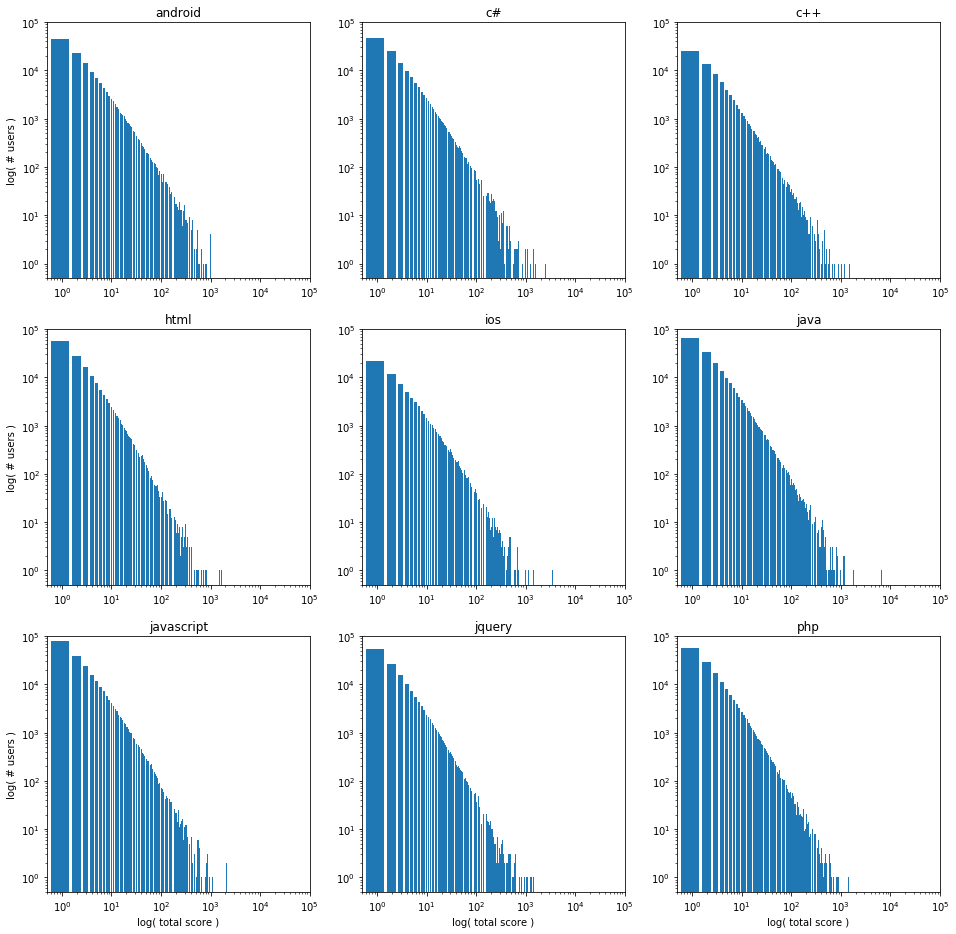

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

binResolution = 1.0

tagNames = d['TagName'].unique()

nrow = 3
ncol = 3

f, axarr = plt.subplots(nrow, ncol, figsize=(16,16))

for i in range(nrow):
    for j in range(ncol):
        x = d[d['TagName'] ==  tagNames[i*ncol+j]]['TotalScore'].values
        y = d[d['TagName'] ==  tagNames[i*ncol+j]]['Counts'].values
        sortId = np.argsort(x)


        binCenters, binCounts = create_hist_data(x, y, binResolution)
        axarr[i,j].bar(binCenters[binCounts > 0], binCounts[binCounts > 0])
        
        axarr[i,j].set_yscale("log")
        axarr[i,j].set_xscale("log")
        
        axarr[i,j].set_xlim([0.5, 1e5])
        axarr[i,j].set_ylim([0.5, 1e5])
        axarr[i,j].set_title(tagNames[i*ncol+j])
        
        if i == nrow-1:
            axarr[i,j].set_xlabel("log( total score )")
        
        if j == 0:
            axarr[i,j].set_ylabel("log( # users )")
        

The plots show that the number users with high score decays faster than 1/score, meaning that number of experts is much smaller compared to the overall population of users answering questions. Given that number of questions on Stack Overflow increase with time, it is important to to match expert users with important interesting questions. 